In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import roc_curve, auc

# Exercicio 01

Neste exercício, aplicamos a regressão logística sobre dados de câncer de mama. O problema consistem em
classificar o câncer em maligno ou benigno baseado em amostras de biopses. Considere o código abaixo e
responda as perguntas que aparecem em seguida.

Perguntas: (considere malignant como a classe “positiva”)

a) Explique o que é a medida de desempenho revocação (ou recall) e calcule manualmente este valor de acordo com os valores apresentados na matriz de confusão dada acima.

b) Explique o que é a medida de desempenho precisão (ou precision) e calcule manualmente este valor de acordo com os valores apresentados na matriz de confusão dada acima.

c) Calcule manualmente as medidas de desempenho sensibilidade e especificidade usando a matriz de confusão acima.

d) Verifique o seu resultado com as funções recall, precision, sensitivity e specificity do pacote
yardstick.

In [ ]:
# Carregando o banco de dados
library(mlbench)
data("BreastCancer")
bc_df <- as_tibble(BreastCancer) %>%
na.omit() # Algumas entradas possuem NAs, vamos remover
# Vamos fazer uma receita para os nossos dados
rec <- recipe(Class ~ ., bc_df) %>%
# Remover a Coluna Id que

não vai nos ajudar
step_rm(Id) %>%
# Converte os seguintes preditores categóricos ordinais para valores
# numéricos
step_ordinalscore(Cl.thickness,
Cell.size,
Cell.shape,
Marg.adhesion,
Epith.c.size) %>%
# Converte as variáveis nominais para dummy variables
# exceto pela saída, que não queremos converter.
step_dummy(all_nominal(),-all_outcomes()) %>%
# O nível Mitoses 6 não tem representantes e
# a variável dummy associada aparece com NAs
# vamos removê-la
step_rm(Mitoses_X6) %>%
# Vamos agora centrar e escalonar nossas
# variáveis
step_center(all_predictors()) %>%
step_scale(all_predictors())
# Podemos regularizar a regressão logística como fazemos
# na regressão Lasso ou Ridge. De fato, o parâmetro
# mixture abaixo é o parâmetro do Elastic-Net, que
# mistura a regularização do Lasso e Ridge. Quando
# mixture = 1 temos o Lasso e quando mixture = 0
# temos a regressão Ridge.
#
# Neste exemplo, desabilitei a regularização
# atribuindo NULL para mixture e fazendo
# penalty = 0.
lr.model <- logistic_reg(penalty = 0

mixture = NULL
) %>%
set_engine("glmnet")
# Vamos dividir o conjunto de dados em teste e treinamento.
# Escolher uma semente para a geração dos números aleatórios
# faz nosso exemplo ser reprodutível.
set.seed(123)
split <- initial_split(bc_df, prop = 0.70)
train <- training(split)
test <- testing(split)
# Preparando a receita com dados de treinamento
rec.prep <- rec %>% prep(train)
# Extraindo dados de treinamento e testes preparados pela receita
train.prep <- juice(rec.prep)
test.prep <- bake(rec.prep,test)
# Ajustando o modelo sobre os dados preparados de treinamento
lr.fit <- lr.model %>% fit(Class ~ ., train.prep)
# Fazendo a predição sobre os dados preparados de teste
test.pred <- test.prep %>%
bind_cols(lr.fit %>% predict(new_data = test.prep))
# Podemos calcular a matriz de confusão usando
# o comando conf_mat do pacote yardstick da
# tidymodels.
conf_mat(test.pred,Class,.pred_class)$table

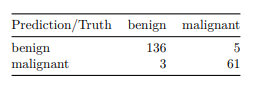

A- O recall mede a quantidade de vezes que o seu modelo acerta em relação ao total de vezes que ele deveria ter acertado.


In [2]:
#Vamos calcular manualmente, imputando os valores da matriz de confusão:

verdadeiros_positivos = 61
falsos_negativos = 3

#Formula Recall

recall = verdadeiros_positivos / (verdadeiros_positivos + falsos_negativos)

print (f"Recall: {recall:.4f}")

Recall: 0.9531


B- A precisão mede o quanto podemos confiar num modelo quando ele prevê que um exemplo pertence a uma determinada classe, de quantos o modelo previu como positivo, quantos ele de fato acertou.

In [3]:
#Vamos calcular manualmente, imputando os valores da matriz de confusão:

verdadeiros_positivos = 61
falsos_positivos = 5

#Formula Precisão

precisao = verdadeiros_positivos / (verdadeiros_positivos + falsos_positivos)

print (f"Precisão: {precisao:.4f}")

Precisão: 0.9242


In [5]:
#C -

#Valores da matriz de confusão

verdadeiros_positivos = 61  # TP
falsos_negativos = 3        # FN
verdadeiros_negativos = 136 # TN
falsos_positivos = 5        # FP

#Sensibilidade (recall)
sensibilidade = verdadeiros_positivos / (verdadeiros_positivos + falsos_negativos)

#Especificidade
especificidade = verdadeiros_negativos / (verdadeiros_negativos + falsos_positivos)


print(f"Sensibilidade (Recall): {sensibilidade:.4f}")
print(f"Especificidade: {especificidade:.4f}")

Sensibilidade (Recall): 0.9531
Especificidade: 0.9645


In [12]:
#D- Adaptando a resolução para uso do da biblioteca Sklearn

from sklearn.metrics import recall_score, precision_score, confusion_matrix


# Valores reais (y_true) e previstos (y_pred) Criando as listas de amostras
y_true = ['benign'] * 136 + ['benign'] * 5 + ['malignant'] * 3 + ['malignant'] * 61
y_pred = ['benign'] * 136 + ['malignant'] * 5 + ['benign'] * 3 + ['malignant'] * 61

# garantindo que tenham o mesmo tamanho, pois o sklearn não lida com taamnhos de amostras diferentes
print(f"Tamanho de y_true: {len(y_true)}")  # Deve ser 205
print(f"Tamanho de y_pred: {len(y_pred)}")  # Deve ser 205

# Cálculo das métricas
recall = recall_score(y_true, y_pred, pos_label='malignant')  # Sensibilidade (Recall)
precision = precision_score(y_true, y_pred, pos_label='malignant')  # Precisão
# Confusion matrix para especificidade
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=['benign', 'malignant']).ravel()
specificity = tn / (tn + fp)
# Exibir os resultados
print(f"Sensibilidade (Recall): {recall:.4f}")
print(f"Precisão (Precision): {precision:.4f}")
print(f"Especificidade: {specificity:.4f}")

Tamanho de y_true: 205
Tamanho de y_pred: 205
Sensibilidade (Recall): 0.9531
Precisão (Precision): 0.9242
Especificidade: 0.9645


In [11]:
# Valores da matriz de confusão
tn = 136
fp = 5
fn = 3
tp = 61


# Sensibilidade (Recall)
sensibilidade = tp / (tp + fn)
# Precisão (Precision)
precisao = tp / (tp + fp)
# Especificidade
especificidade = tn / (tn + fp)


print(f"Sensibilidade (Recall): {sensibilidade:.4f}")
print(f"Precisão (Precision): {precisao:.4f}")
print(f"Especificidade: {especificidade:.4f}")

Sensibilidade (Recall): 0.9531
Precisão (Precision): 0.9242
Especificidade: 0.9645


# Exercicio 02

Continuando o exercício anterior, vamos ajustar os parâmetros dos modelos SVM e regressão logística usando
como critério a área debaixo da curva ROC (AUC da ROC). Para a regressão logística iremos escolher os
parâmetros mixture e penalty para fazer uma regressão regularizada. Já no caso do SVM iremos usar um
kernel exponencial (ou rbf) e vamos ajustar os valores do parâmetro σ do kernel e o fator de penalização da
margem macia C.
O código abaixo já faz o que foi solicitado para a regressão logística. Você deve incluir agora a classificação
SVM. O modelo do SVM com kernel rbf no tidymodels pode ser criado com o comando svm_rbf, ajustando
os parâmetros sigma e cost. Use o motor kernlab para o SVM (ou seja, faça set_engine("kernlab"))

In [15]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

df = pd.DataFrame(data.data, columns = data.feature_names)
df['target']= data.target

print(df.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

In [17]:

# Definir variaveis
X = data.data
y = data.target

# Configurar validação cruzada (10 folds)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Métrica de avaliação AUC
scorer = make_scorer(roc_auc_score, needs_proba=True)

# 1. Regressão Logística

# Definir o grid de hiperparâmetros para regressão logística
param_grid_lr = {
   'classifier__penalty': ['l2'],  # Regularização L2
   'classifier__C': np.logspace(-3, 3, 10),  # Regularização: 0.001 a 1000
   'classifier__solver': ['lbfgs']  # Algoritmo compatível com L2
}
# Criar um pipeline para a regressão logística
pipeline_lr = Pipeline([
   ('scaler', StandardScaler()),  # Escalar os dados
   ('classifier', LogisticRegression(max_iter=10000, random_state=42))
])
# Configurar a busca em grade para regressão logística
grid_search_lr = GridSearchCV(
   pipeline_lr,
   param_grid=param_grid_lr,
   scoring=scorer,
   cv=cv,
   verbose=1,
   n_jobs=-1
)
# Ajuste o modelo de regressão logística

grid_search_lr.fit(X, y)

print("Melhores parâmetros para Regressão Logística:", grid_search_lr.best_params_)
print("Melhor AUC ROC para Regressão Logística:", grid_search_lr.best_score_)

# 2. SVM com kernel RBF
# Definir o grid de hiperparâmetros para SVM
param_grid_svm = {
   'classifier__C': np.logspace(-3, 3, 10),  # Regularização
   'classifier__gamma': np.logspace(-3, 3, 10),  # Parâmetro do kernel RBF
   'classifier__kernel': ['rbf']  # Tipo de kernel
}
# Criar um pipeline para SVM
pipeline_svm = Pipeline([
   ('scaler', StandardScaler()),
   ('classifier', SVC(probability=True, random_state=42))
])
# Configurar a busca em grade para SVM
grid_search_svm = GridSearchCV(
   pipeline_svm,
   param_grid=param_grid_svm,
   scoring=scorer,
   cv=cv,
   verbose=1,
   n_jobs=-1
)
# Ajustar o modelo SVM
grid_search_svm.fit(X, y)


print("Melhores parâmetros para SVM:", grid_search_svm.best_params_)
print("Melhor AUC ROC para SVM:", grid_search_svm.best_score_)

#Análise dos resultados
results_lr = pd.DataFrame(grid_search_lr.cv_results_)
results_svm = pd.DataFrame(grid_search_svm.cv_results_)

# Mostrar os 3 melhores modelos para cada algoritmo
print("\nTop 3 modelos para Regressão Logística (AUC ROC):")
print(results_lr.nlargest(3, 'mean_test_score')[['params', 'mean_test_score']])
print("\nTop 3 modelos para SVM (AUC ROC):")
print(results_svm.nlargest(3, 'mean_test_score')[['params', 'mean_test_score']])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Melhores parâmetros para Regressão Logística: {'classifier__C': 0.46415888336127775, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Melhor AUC ROC para Regressão Logística: 0.9956445406445406
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Melhores parâmetros para SVM: {'classifier__C': 10.0, 'classifier__gamma': 0.004641588833612777, 'classifier__kernel': 'rbf'}
Melhor AUC ROC para SVM: 0.9964285714285713

Top 3 modelos para Regressão Logística (AUC ROC):
                                              params  mean_test_score
4  {'classifier__C': 0.46415888336127775, 'classi...         0.995645
3  {'classifier__C': 0.1, 'classifier__penalty': ...         0.995642
2  {'classifier__C': 0.021544346900318832, 'class...         0.994976

Top 3 modelos para SVM (AUC ROC):
                                               params  mean_test_score
61  {'classifier__C': 10.0, 'classifier__gamma': 0...         0.996429
62  {'classifier__C': 10.0, 'classifier__gamma': 0..

# Exercício 03

Agora que você já escolheu os melhores parâmetros para os modelos regressão logística e o SVM com kernel
rbf, vamos agora traçar curvas ROC obtidas por um processo de validação cruzada para os dois modelos -
usando os parâmetros com melhor resultado do exercício anterior.
Abaixo segue um exemplo de como fazer para um modelo de regressão logística (não utilizei o melhor modelo,
isso é somente um exemplo). Além de incluir os melhores parâmetros para a regressão logística, faça também
os gráficos para o SVM com os melhores parâmetros.

In [ ]:
lr.model <- logistic_reg( penalty = 0,
mixture = NULL) %>%
set_engine("glmnet")
folds <- vfold_cv(v = 5,bc_df)
fit.res <- fit_resamples( lr.model, # Modelo
rec, # Receita sem preparo
resamples = folds, # Conjuntos de validação cruzada

# Vamos falar para ele salvar as predições!
control = control_resamples(save_pred = TRUE) )

Agora que temos modelos ajustados e testados em cada um dos conjuntos da validação cruzada, vamos fazer
o gráfico ROC. Note que fit.res possui os resultados das predições empacotados, vamos usar unnest para
desempacotar.

In [ ]:
fit.res
predicoes <- fit.res %>%
unnest(.predictions)
# Vamos fazer um gráfico da curva roc por fold
predicoes %>%
group_by(id) %>%
roc_curve(Class,.pred_benign) %>%
ggplot(aes(x = 1-specificity, y = sensitivity, color = id) ) +
geom_path(size = 1.2, alpha = 0.8) +
geom_abline(lty = 2, color = "gray", size = 1.5) +
coord_equal()
# Vamos fazer um gráfico médio dos folds

In [ ]:
predicoes %>%
mutate( modelo = "Reg. Logística") %>%
group_by(modelo) %>%
roc_curve(Class,.pred_benign) %>%
ggplot(aes(x = 1-specificity, y = sensitivity, color = modelo) ) +
geom_path(size = 1.2, alpha = 0.8) +
geom_abline(lty = 2, color = "gray", size = 1.5) +
coord_equal()


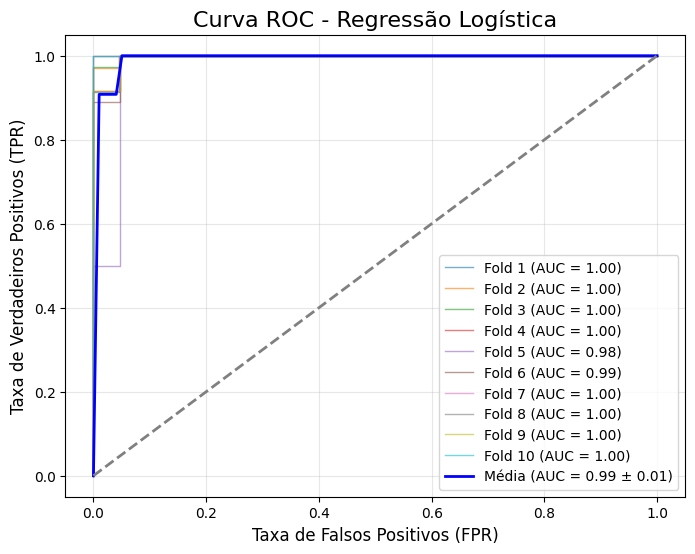

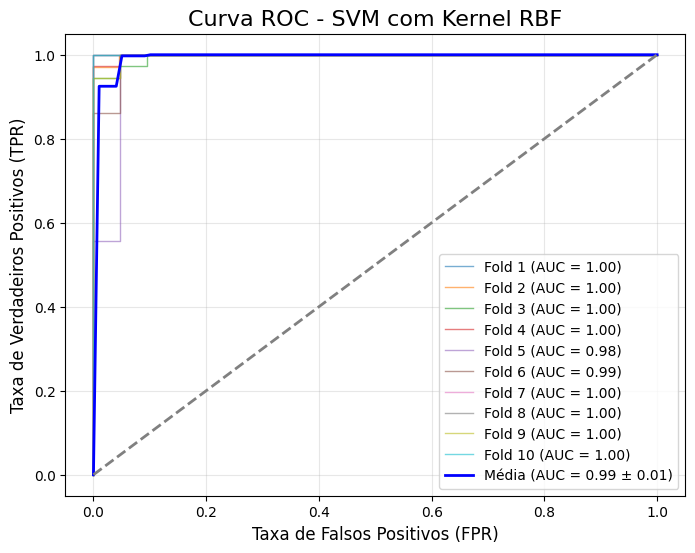

In [20]:
# Configuração de validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
### Configuração dos modelos com os melhores parâmetros ###
# Regressão Logística com C=0.464
lr_pipeline = Pipeline([
   ('scaler', StandardScaler()),
   ('classifier', LogisticRegression(C=0.464, penalty='l2', solver='lbfgs', max_iter=10000, random_state=42))
])
# SVM com C=10.0 e gamma=0.01
svm_pipeline = Pipeline([
   ('scaler', StandardScaler()),
   ('classifier', SVC(C=10.0, gamma=0.01, kernel='rbf', probability=True, random_state=42))
])
### Função para calcular e plotar curvas ROC ###
def plot_roc_curves(model_pipeline, model_name):
   tprs = []  # True Positive Rates
   aucs = []  # AUCs
   mean_fpr = np.linspace(0, 1, 100)  # False Positive Rates uniformes para média
   plt.figure(figsize=(8, 6))
   for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):

       # Dividir os dados em treino e teste para o fold atual
       X_train, X_test = X[train_idx], X[test_idx]
       y_train, y_test = y[train_idx], y[test_idx]

       # Ajustar o modelo e fazer predições de probabilidade
       model_pipeline.fit(X_train, y_train)
       y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

       # Calcular a curva ROC
       fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
       roc_auc = auc(fpr, tpr)
       aucs.append(roc_auc)
       plt.plot(fpr, tpr, lw=1, alpha=0.6, label=f"Fold {i+1} (AUC = {roc_auc:.2f})")

       # Interpolar para média
       tpr_interp = np.interp(mean_fpr, fpr, tpr)
       tpr_interp[0] = 0.0
       tprs.append(tpr_interp)

   # Calcular a média e intervalo de confiança
   mean_tpr = np.mean(tprs, axis=0)
   mean_tpr[-1] = 1.0
   mean_auc = auc(mean_fpr, mean_tpr)
   std_auc = np.std(aucs)
   plt.plot(mean_fpr, mean_tpr, color='blue', lw=2,
            label=f'Média (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

   # Linha de referência (random guess)
   plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)

   # Personalização do gráfico
   plt.title(f"Curva ROC - {model_name}", fontsize=16)
   plt.xlabel("Taxa de Falsos Positivos (FPR)", fontsize=12)
   plt.ylabel("Taxa de Verdadeiros Positivos (TPR)", fontsize=12)
   plt.legend(loc="lower right", fontsize=10)
   plt.grid(alpha=0.3)
   plt.show()
# Plotar as curvas ROC para Regressão Logística
plot_roc_curves(lr_pipeline, "Regressão Logística")
# Plotar as curvas ROC para SVM
plot_roc_curves(svm_pipeline, "SVM com Kernel RBF")

# Exercício 04

O algoritmo Perceptron é um dos mais simples algoritmos para classificação. Neste exercício, vamos
implementar este algoritmo e testá-lo sobre o banco de dados iris, com as classes: setosa contra outras
(que passa a ser um problema de classificação binária e linearmente separável).
O banco de dados iris pode ser carregado da seguinte forma. No código abaixo juntamos as classes que não
são setosa na classe “outra”

In [ ]:
data("iris")
df <- as_tibble(iris) %>%
# Fazendo a coluna Species ser charactere e não
# factor para usarmos o if_else abaixo
mutate( Species = as.character(Species) ) %>%
# A linha abaixo cria a coluna Classe que terá versicolor se
# a planta é dessa espécie e outra caso contrário.
mutate( Classe = if_else( Species == "setosa", Species, "outra")) %>%
# Removendo a coluna Species, porque não precisamos
# mais dela
select(-Species) %>%
# Vamos fazer a variável Classe ser um factor
mutate( Classe = factor(Classe, levels=c("setosa","outra")) )
# Para ver se está tudo ok e contar o número de entradas por
# classe, podemos rodar o seguinte:
df %>% count(Classe)

Complete a implementação do método perceptron feita pelas funções perceptron.fit e perceptron.predict.
A função perceptron.fit faz o ajuste do método com os dados de treinamento e a função
perceptron.predict deve retornar a classe do vetor x com o seguinte critério: se w
tx + b > 0
classe é “outra” e se w
tx + b < 0 a classe é “setosa”, para w e b ajustados pela função perceptron.fit.
Após completar o código, calcule a acurácia do modelo com um processo de validação cruzada com k folds.
Note que não poderemos usar a função fit_resamples já que ela depende de um modelo do tidymodels

In [ ]:
## Função para fazer o ajuste do perceptron
perceptron.fit <- function( form, # uma fórmula para treinar
df, # dataframe para treinar
eta = 0.01) # taxa de aprendizado
{
# Obtem a dataframe que precisamos
# para treinar os dados a partir da
# formula:
train_df <- model.frame(form,df)
# Extrai a coluna dos y e depois colocamos
# os valores -1 e +1
  classes <- levels(train_df[,1])
y <- train_df[,1] %>% as.integer()
y <- (y - 1)*2-1
# Extrai as colunas dos X
X <- as.matrix(train_df[,-1])
# Vetor normal do hiperplano e o intercepto
w <- vector("numeric",length=ncol(X))
b <- 0
# Implementar o perceptron:
e <- 1
while(e != 0)
{
e <- 0
# Embaralhando o conjunto de indices
index <- sample(1:nrow(X))
for( i in 1:nrow(X) )
{
# ponto para testar
j <- index[i]
x <- as.numeric(X[j,])
###<<< SEU CODIGO AQUI >>>###
}
}
return(list("formula" = form, # formula usada no treinamento
"classes" = classes, # nomes das classes
"normal" = w, "intercepto_y" = b))
}
# Função para fazer a predição
perceptron.predict <- function( percep.fit, # saída da função perceptron.fit
new_data) # dados de teste
{
form <- percep.fit$formula
classes <- percep.fit$classes
w <- percep.fit$normal
b <- percep.fit$intercepto_y
# Extrai as colunas do X
# -- Aqui precisamos gerar a matriz X de acordo com a fórmula,
# queremos usar a fórmula mesmo se new_data não contêm a
# coluna das classes.
class_column <- as.character(form[2])
if( class_column %in% names(new_data) )
test_df <- model.frame(form[-2],new_data %>% select(-class_column) )
else
test_df <- model.frame(form[-2],new_data)
X <- as.matrix(test_df)
# Calcular w * x + b, para os pontos em new_data
# e retorna a classe de cada ponto.
# Cria um vetor para retornar
pred <- factor(vector("character",length=nrow(X)),levels=classes)
for( i in 1:nrow(X) )
{
x <- as.numeric(X[i,])
###<<< SEU CODIGO AQUI >>>###
}
return(tibble(.pred = pred))
}
## Fazendo a validação cruzada com k = 10,
## repeats = 3 repete a geração de folds 3 vezes,
## nos dando 30 folds. Repetir é útil para ter mais
## precisão nos resultados.
splits <- vfold_cv(df,k = 10, repeats= 3)
acc_results <- vector("numeric",length=nrow(splits))
for( i in 1:nrow(splits) )
{
s <- splits$splits[[i]]
train <- analysis(s)
test <- assessment(s)
percep.fit <- perceptron.fit(Classe ~ ., train)
test_pred <- perceptron.predict(percep.fit,test) %>%
bind_cols(test) %>% accuracy(Classe,.pred)
acc_results[i] <- test_pred$.estimate
}
cat("Acurácia média = ",mean(acc_results),"\n")


Por fim, note que podemos gerar a fronteira de decisão do perceptron da seguinte forma:

In [ ]:
library(modelr)
# Geramos uma malha de pontos para desenhar a fronteira
# a malha possui pontos sobre toda a região em que os
# pontos do banco tomam valor. (Geramos 50 x 50 pontos)
plot_grid <- expand_grid( Sepal.Length = seq_range(df$Sepal.Length,50),
Petal.Length = seq_range(df$Petal.Length,50))
df <- df %>% select( Sepal.Length, Petal.Length, Classe )
# Adicionamos a predição das classes à
percep.fit <- perceptron.fit(Classe ~ ., df)
plot_grid_pred <- plot_grid %>%
mutate( pred = perceptron.predict(percep.fit,plot_grid)$.pred)
# Fazemos o gráfico
ggplot(plot_grid_pred, aes(Sepal.Length,Petal.Length))+
geom_contour(aes(z= as.integer(pred)),
alpha = 0.5, show.legend = F,breaks = c(1L,2L),
size=1.2, color ="red") +
geom_point(data = df, aes(z=NULL,colour = Classe),size=2) +
labs(title = "Fronteira de Decisão para o Perceptron")


Acurácia média: 0.99


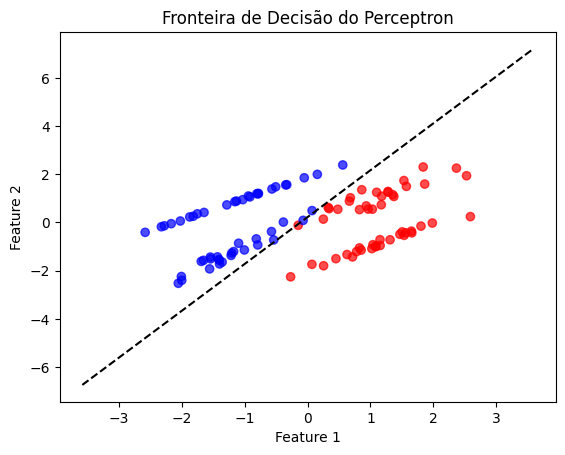

In [21]:
#Fazendo a "tradução" do R para o python temos:

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Função para treinar o Perceptron
def perceptron_fit(X, y, max_epochs=100):
   # Inicializar o vetor de pesos (inclui bias como o último elemento)
   w = np.zeros(X.shape[1] + 1)
   # Iterar por épocas
   for epoch in range(max_epochs):
       errors = 0
       for i in range(X.shape[0]):
           x_i = np.append(X[i], 1)  # Adiciona o bias ao vetor de entrada
           y_pred = np.sign(np.dot(w, x_i))  # Previsão do perceptron
           if y_pred == 0:  # Garantir que a previsão não seja 0
               y_pred = -1
           if y_pred != y[i]:  # Atualização dos pesos
               w += y[i] * x_i
               errors += 1
       if errors == 0:  # Parar se não houver erros
           break
   return w
# Função para realizar a predição com o Perceptron
def perceptron_predict(X, w):
   predictions = []
   for i in range(X.shape[0]):
       x_i = np.append(X[i], 1)  # Adiciona o bias ao vetor de entrada
       y_pred = np.sign(np.dot(w, x_i))
       predictions.append(y_pred if y_pred != 0 else -1)
   return np.array(predictions)
# Função para validação cruzada
def perceptron_cross_validate(X, y, k=10, max_epochs=100):
   skf = StratifiedKFold(n_splits=k)
   accuracies = []
   for train_index, test_index in skf.split(X, y):
       X_train, X_test = X[train_index], X[test_index]
       y_train, y_test = y[train_index], y[test_index]
       # Treina o perceptron
       w = perceptron_fit(X_train, y_train, max_epochs)
       # Predições no conjunto de teste
       y_pred = perceptron_predict(X_test, w)
       # Calcula a acurácia
       acc = accuracy_score(y_test, y_pred)
       accuracies.append(acc)
   return np.mean(accuracies)
# Gerar um conjunto de dados de exemplo (exemplo semelhante ao iris do R)
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=2, n_redundant=0, random_state=42)
y = np.where(y == 0, -1, 1)  # Ajustar as classes para serem -1 e 1
# Validação cruzada
accuracy = perceptron_cross_validate(X, y, k=10)
print(f"Acurácia média: {accuracy:.2f}")
# Visualização da fronteira de decisão
def plot_decision_boundary(X, y, w):
   plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
   # Gerar linha de decisão
   x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
   y_min, y_max = -(w[0] * x_min + w[2]) / w[1], -(w[0] * x_max + w[2]) / w[1]
   plt.plot([x_min, x_max], [y_min, y_max], 'k--')
   plt.xlabel("Feature 1")
   plt.ylabel("Feature 2")
   plt.title("Fronteira de Decisão do Perceptron")
   plt.show()
# Treinar modelo completo e plotar fronteira
w = perceptron_fit(X, y)
plot_decision_boundary(X, y, w)



A Parte do "coloque seu código aqui" seria esta:

In [ ]:
for epoch in range(max_epochs):
   errors = 0
   for i in range(X.shape[0]):
       x_i = np.append(X[i], 1)  # Adiciona o bias
       y_pred = np.sign(np.dot(w, x_i))
       if y_pred == 0:
           y_pred = -1
       if y_pred != y[i]:  # Atualização dos pesos
           w += y[i] * x_i
           errors += 1
   if errors == 0:
       break